# N-gram Language model


In this task you will build a language model based on the corpus you prepared in Task 1. 

The solution to task 1 is available [here](https://colab.research.google.com/drive/1m17xuC7pX8d1L_UPxTS4UUG3cElgiwyh). 


In Task 2, we will work on the following items:

* Calculating the probabilities of n-grams using Maximum Likelihood Estimation and the equation: 
$$p(token / prefix) = \frac{count(prefix + token)} {count(prefix)}  $$

* Assessing the relevance of a sentence by calcultaing its perplexity  
* Handling n-grams that are not present in the corpus with Laplace smoothing
* Creating a text generator function based on the n-gram model
* Generating text with temperature sampling


The goal is to have a language model that can 

* generate text
* assess the probability of a sentence

And to have a measure of the quality of the language model.

Let's go!







# Loading the dataset

Let's import the library and load the dataset that we created in the previous task


In [0]:
import pandas as pd
import numpy as np
import re
import csv
from tqdm import tqdm
from collections import defaultdict, Counter
from nltk.util import ngrams

In [0]:
# Set some global parameters

# Displaying all columns when displaying dataframes
pd.options.display.max_columns = None

# We will work with trigrams 
ngrams_degree = 3


In [0]:
# if there's a problem with the versions of the librairies, you can . . uncomment this line and install the proper versions

# !pip install -r requirements.txt

In [0]:
# Load data into pandas dataframe, shuffle it and reset the index
df = pd.read_csv('https://alexip-ml.s3.amazonaws.com/stackexchange_812k.tokenized.csv.gz', compression='gzip').sample(frac = 1, random_state = 8).reset_index(drop = True)


In [0]:
# Display the dimensions of the dataframe 
print("{}\n".format(df.shape))
# and the 1st 5 lines
print(df.head())

(789649, 7)

   post_id  parent_id  comment_id  \
0   161009        NaN    309845.0   
1   156252        NaN    298634.0   
2   423360        NaN    790161.0   
3   268623        NaN         NaN   
4   433662        NaN    808873.0   

                                                text category  \
0  I can't disclose the algorithm, but I can cert...  comment   
1  I plan to leave the answer to this question in...  comment   
2  Wait, I need to clarify how is Half-normal dis...  comment   
3  I am fitting several models of the form.. glm ...     post   
4  If you really want to calculate some p-value u...  comment   

                                              tokens  n_tokens  
0  i can ' t disclose the algorithm , but i can c...        40  
1  i plan to leave the answer to this question in...        84  
2  wait , i need to clarify how is half - normal ...        25  
3  i am fitting several models of the form .. glm...        82  
4  if you really want to calculate some p - valu

The tokens were saved as strings with space separated tokens for simplicity purposes. 

Let's transform the tokens colum as an actual list of tokens.

In [0]:
df['tokens'] = df.tokens.apply(lambda txt : txt.split())

In [0]:
df.sample(5).tokens.values

array([list(['my', 'answer', 'is', 'relevant', 'per', "'", 's', 'comment', 'which', 'stats', 'tests', 'to', 'use', '?']),
       list(['your', 'suggested', 'method', 'doesn', "'", 't', 'seem', 'to', 'account', 'for', 'autocorrelation', '-', 'i', '.', 'e', '.', 'values', 'for', 'the', 'response', 'will', 'be', 'more', 'similar', 'the', 'closer', 'together', 'in', 'time', 'the', 'observations', 'are', ',', 'violating', 'any', 'assumptions', 'of', 'independent', 'data', 'points', '.', 'would', 'it', 'be', 'better', 'to', 'e', '.', 'g', '.', 'run', 'multiple', 'arma', 'models', ',', 'each', 'with', 'a', 'different', 'adstock', 'rate', ',', 'then', 'use', 'something', 'like', 'aic', 'to', 'pick', 'the', 'final', 'model', '?']),
       list(['incidentally', ',', 'the', 'factorisation', 'theorem', 'argument', 'isn', "'", 't', 'mine', 'but', 'a', 'result', 'which', 'goes', 'back', 'to', 'fisher', 'neyman', 'and', 'is', 'in', 'any', 'intro', 'stat', 'inference', 'text', '.']),
       list(['you

We split the dataset into a training and a testing subset. 

The testing subset is somposed of the titles, the train subset is composed of posts and comments


In [0]:
df_train = df[df.category.isin(['post','comment'])].copy()
df_test = df[df.category.isin(['title'])].copy()

In [0]:
# Display the dimensions of the dataframe 
print("-- Training set: {}\n".format(df_train.shape))
# and the 1st 5 lines
print(df_train.head())

print("\n-- Testing set {}\n".format(df_test.shape))
print(df_test.head())


-- Training set: (705964, 7)

   post_id  parent_id  comment_id  \
0   161009        NaN    309845.0   
1   156252        NaN    298634.0   
2   423360        NaN    790161.0   
3   268623        NaN         NaN   
4   433662        NaN    808873.0   

                                                text category  \
0  I can't disclose the algorithm, but I can cert...  comment   
1  I plan to leave the answer to this question in...  comment   
2  Wait, I need to clarify how is Half-normal dis...  comment   
3  I am fitting several models of the form.. glm ...     post   
4  If you really want to calculate some p-value u...  comment   

                                              tokens  n_tokens  
0  [i, can, ', t, disclose, the, algorithm, ,, bu...        40  
1  [i, plan, to, leave, the, answer, to, this, qu...        84  
2  [wait, ,, i, need, to, clarify, how, is, half,...        25  
3  [i, am, fitting, several, models, of, the, for...        82  
4  [if, you, really, want, to, 

# Counting bigrams and following tokens
We build a counts object defined as a defaultdict(Counter). 

Taking into account all trigrams (ngrams_degree = 3) that we break into prefix (bigrams) followed by single tokens. 

The counts object will have the bigrams as keys and for each key a Counter of all the potential tokens. 

For instance, if the corpus contains a 100 instances of "*how many people*" and a 120 instances of "*how many times*" we would get the following entry:

    counts[('how', 'many')] = Counter('people': 100, 'times': 120, .... )

Similarly if the corpus contains "*the model is*" 500 times and "*the model parameters*" 200 times, we end up with:

    counts[('the', 'model')] = Counter('is': 500, 'parameters': 200, .... )

To split the tokens into bigramns we use the [ntlk.ngrams](https://www.nltk.org/api/nltk.html#nltk.util.ngrams) function:


    Return the ngrams generated from a sequence of items, as an iterator.
    For example:

    >>> from nltk.util import ngrams
    >>> list(ngrams([1,2,3,4,5], 3))
    [(1, 2, 3), (2, 3, 4), (3, 4, 5)]

The next cell should take a couple of minutes.

Note that we build the mode on the training subset df_train and leave the testing subset aside.




In [0]:
counts = defaultdict(Counter)
for tokens in tqdm(df_train.tokens.values):
    for ngram in ngrams(
          tokens, 
          n= ngrams_degree,  
          pad_right=True, 
          pad_left=True, 
          left_pad_symbol="<s>", 
          right_pad_symbol="</s>"):
      
        prefix = ngram[:ngrams_degree-1]
        token = ngram[ngrams_degree-1]
        counts[prefix][token] +=1


100%|██████████| 705964/705964 [02:16<00:00, 5179.64it/s]


We can explore the counts object

In [0]:
print("we have {} bigrams".format(len(counts.keys())))

we have 3332935 bigrams


In [0]:
import random
for i in range(5):
    prefix = random.choice(list(counts.keys()))
    print("{}: \t{}".format(prefix,counts[prefix]))

('ecdf', 'output'): 	Counter({'for': 1})
('statistic', 'whether'): 	Counter({'my': 1})
(',', 'texvars'): 	Counter({',': 1, '.': 1})
('act', 'out'): 	Counter({'within': 1, 'with': 1, 'together': 1})
('object', 'created'): 	Counter({'by': 9, 'in': 2, 'from': 1})


Let's look at the number of potential tokens for each bigram. 



In [0]:
tokens_count = [ len(v)   for k,v in counts.items()  ]

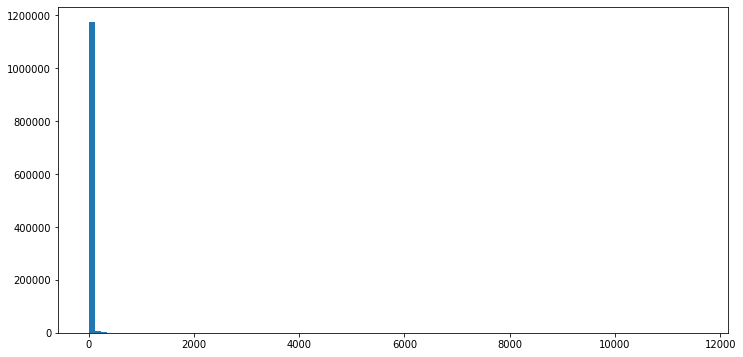

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(12,6))
plt.hist(tokens_count, bins = 100);

As we can see, most bigrams only have one potential following token. 


In [0]:
bigrams_with_single_tokens = [ k   for k,v in counts.items() if len(v) == 1 ]
bigrams_with_two_tokens = [ k   for k,v in counts.items() if len(v) == 2 ]

print("{} bigrams_with_single_tokens".format(len(bigrams_with_single_tokens)))
print("{} bigrams_with_two_tokens".format(len(bigrams_with_two_tokens)))


2146242 bigrams_with_single_tokens
446829 bigrams_with_two_tokens


2 bigrams have over 10,000 potential tokens:

In [0]:
tokens_dict = { k:len(v)   for k,v in counts.items() if len(v) > 10000 }
tokens_dict


{('<s>', '<s>'): 11564, ('of', 'the'): 10815}

Note: At this point we could decide to remove all the bigrams with a single potential token as not being significant. This would reduce the size of the model. We will see later on if that actually improves the model or degrades it.

# token / prefix probabilities

To obtain token / prefix probabilities using the Maximum Likelihood Estimator, we must simply normalize each (prefix - token) count by the total number of the prefix occurence. 

$$p(token / prefix) = \frac{count(prefix + token)} {count(prefix)}$$


Keeping the same defaultdict(Counter) structure for the freq object, we should obtain something similar to 


    freq[('how', 'many')] = {'people': 0.14, 'times': 120, .... }

with 
* p(people / how many) = c('how many people') / c('how many') 
* p(times / how many) = c('how many times') / c('how many')





In [0]:
freq = defaultdict(dict)
for prefix, tokens in counts.items():
    total = sum( counts[prefix].values()  )
    for token, c in tokens.items():
        freq[prefix][token] = c / total


Which gives us the following sample:

In [0]:
for i in range(5):
    prefix = random.choice(list(freq.keys()))
    print("{}: \t{}".format(prefix,freq[prefix]))

('new', 'trainset'): 	{',': 0.5, 'has': 0.5}
('model', 'json'): 	{'model': 0.5, 'serialize': 0.5}
('intercept', 'det'): 	{'correlation': 1.0}
('probabilty', 'equal'): 	{'to': 1.0}
('theorem', 'verifying'): 	{'that': 1.0}


# Text generation

Next we write a text generating function which:
* takes a bigram as input
  * Note: In this version of the function, the bigram must exist in the corpus
* generates a new token by sampling the available tokens related to the bigram using the freq object as distribution 
* sliding the bigram to include the new token
* generating a new token based on the new bigram
* stopping when the text is N tokens long or the latest token is the end of string symbol



In [0]:
def generate(text, n_words = 40):
    for i in range(n_words):
        prefix = tuple(text.split()[-ngrams_degree+1:])
        # no available text
        if len(freq[prefix]) == 0:
            break
        candidates  = list(freq[prefix].keys())
        probas      = list(freq[prefix].values())
        text       += ' ' + np.random.choice(candidates, p = probas)
        if text.endswith('</s>'):
            break

    return text


Now let's have some fun with that language model.

You can choose any seed bigramns as long as it is present in the corpus. 

In [0]:
text      = 'the model'
print()
print(generate(text))

print()
text      = 'that distribution'
print(generate(text))

print()
text      = 'to determine'
print(generate(text))



the model for every possible single - step random walks and then you could get some non - response curves for individual distribution identification and confidence limits for the comments , why would it just sounds horribly wrong in running mixed design

that distribution . also do not necessarily prior experiment , or with margins that is relevant to ordinal , , , , . e - . - . . . . - . - - el - khouri doi . - .

to determine the virality of the models you ' re asking something different to the f - m q . recode readings as a function of y . for this . the original data ' data will look like . you are


# Temperature sampling

As you may have noticed, for some bigrams, one particular token may be much more frequent than the others potential tokens. 

For instance:

* ('building', 'machine'): 	{'learning': 0.875, 'classification': 0.125}

when generating the next token based on the bigram "*building machine*", most of the times the word "learning" will be chosen instead of "classification".

In order to compensate these imbalances and improve the chances of less frequent tokens to be chosen we can sample with temperature.

In order to increase the randomness of the next token selection given a prefix, we can flatten the distribution using the temperature $$\tau$$ to define a new probability distribution as such:

$$f_{\tau}(p_i) = \frac{ p_i^{\frac{1}{\tau}} }{ \sum_j p_j^{\frac{1}{\tau}} }$$

See [this post](https://stats.stackexchange.com/questions/255223/the-effect-of-temperature-in-temperature-sampling) for a more in-depth explanation on temperature sampling.




In [0]:
def generate_temp(text, temperature = 1, n_words=30):
    for i in range(n_words):
        prefix = tuple(text.split()[-ngrams_degree+1:])
        # no available next word
        if len(freq[prefix]) == 0:
            break
        candidates  = list(freq[prefix].keys())
        initial_probas = list(freq[prefix].values())
        # modify distribution
        denom   = sum( [ p ** temperature for p in initial_probas ] )
        probas  = [ p ** temperature / denom  for p in initial_probas  ]

        text       += ' ' + np.random.choice(candidates, p = probas)
        if text.endswith('</s>'):
            break

    return text


Let's generate some text with different values for the temperature.

The higher the temperature, the less chaotic (and shorter) the generated text will end up being.

In [0]:
text  = 'the model'
# text  = 'to determine'
# text  = 'not sure'

for tau in [0.01, 0.5, 1, 3, 10]:
  print(tau)
  print(generate_temp(text, temperature = tau))



0.01
the model closely . that watson ’ s measurements and consider y - width is nothing degenerate about the rep put your finger than there will in fact correct because not everybody
0.5
the model even asymptotically the posterior parameters for both prediction that has calculated tau -. , ncol arima mean metrics such as mi . second model b to d vectors or context
1
the model at the beginning of one where a is on noise levels . all the monthly intervals . in particular with time series , go - to - one - sided
3
the model . i have a look at the end . </s>
10
the model . </s>


# Perplexity

Let's now implement a way to measure the quality of our model.

The idea is to estimate the probability of a test sentence given our model. 
An uncommon sentence should be less probable than a common one.


Notes : 
  1. At this point the sentence should exist in the corpus. Our model does not know yet how to handle out-of-vocabulary (OOV) bigrams, trigrams or tokens.
  2. To avoid the problem of underflow caused by multiplying multiple very small floats, we work in the log space:

So instead of calculating perplexity with (case ngrams_degree = 3):
 
$$PP(w_{1},\cdots, w_N) = ( \prod_{i = 3}^{N} \frac{1}{ p(w_i/ w_{i-2}w_{i-1} )} )^{\frac{1}{N}}$$

We compute

$$PP(w_{1},\cdots, w_N) = \exp [ - \frac{1}{N} {\sum_{i = 3}^{N} \log {p(w_i/ w_{i-2}w_{i-1}} } ) ]$$



In [0]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()


def perplexity(sentence):
    sentence = tokenizer.tokenize(sentence.lower())
    N = len(sentence)
    logprob = 0
    
    for ngram in ngrams(
          sentence, 
          n= ngrams_degree,  
          pad_right=True, pad_left=True, 
          left_pad_symbol="<s>", right_pad_symbol="</s>"):
        try:
          prefix = ngram[:ngrams_degree-1] 
          token = ngram[ngrams_degree-1]
          logprob += np.log( freq[ prefix ][token]  )
        except:
            pass

    return np.exp(- logprob / N)



Let's calculate the perplexity on some sentences.

Take the time to see how the perplexity score varies when you . . modify the sentence. For instance compare the perplexity for

* *the difference between the two approaches is discussed here.*
* *the difference between the two approaches is discussed here*
* *the difference between the two approaches*


In [0]:
sentence = "the difference between the two approaches is discussed here"
print("[perplexity {:.2f}] {}".format(perplexity(sentence), sentence))

sentence = "this question really belongs on a different site"
print()
print("[perplexity {:.2f}] {}".format(perplexity(sentence), sentence))

sentence = "The function may only be linear in the region where the points were taken"
print()
print("[perplexity {:.2f}] {}".format(perplexity(sentence), sentence))


[perplexity 22.63] the difference between the two approaches is discussed here

[perplexity 38.12] this question really belongs on a different site

[perplexity 72.18] The function may only be linear in the region where the points were taken


# Out of Vocabulary (OOV) 

The main weakness of our model so far is that it does not know how to handle elements that are not already in the original corpus.

Since both when generating text and when calculating perplexity we use the count of the prefix in the corpus, when that prefix is missing, the counts = 0  which causes problems with logs and divisions.

To remediate to that problem we can artificially assign a probability (although a very low one) to missing ngrams and tokens.

This method is called Laplace smoothing. It relies on calculating the frequency of a token / prefix with:

$$ p(token / prefix) = \frac{ count( prefix + token) + \delta}{count(prefix) + \delta \times |N| }$$


Where 

* N is the total number of prefixes in the model
* delta is an arbitrary number 

When the prefix is missing from the original corpus, the probability of a token / prefix will now be:

$$p(token / prefix) = \frac{1} { | N |}$$

Let's implement that perplexity with Laplace Smoothing








In [0]:
def perplexity_laplace(sentence,delta = 1):
    sentence = tokenizer.tokenize(sentence.lower())
    N = len(sentence)
    logprob = 0
    for ngram in ngrams(
          sentence, 
          n= ngrams_degree,  
          pad_right=True, pad_left=True, 
          left_pad_symbol="<s>", right_pad_symbol="</s>"):
        prefix = ngram[:ngrams_degree-1]
        token = ngram[ngrams_degree-1]
        if prefix in list(counts.keys()):
            total = sum( counts[prefix].values()  )
            if token in counts[prefix].keys():
                # normal calculation
                logprob += np.log( (counts[prefix][token] + delta)/ (total + delta * N ) )
            else:
                logprob += np.log( ( delta)/ (total + delta * N ) )
        else:
            logprob += - np.log( N )
  
    return np.exp(-logprob / N)



We can now calculate the perplexity of sentences that were not present in the original corpus. 

For instance: 

In [0]:
sentence = "this model belongs on a different planet"
print("[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 10), sentence))

sentence = "this question really belongs on a different site."
print("[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 10), sentence))


[perplexity 142.66] this model belongs on a different planet
[perplexity 35.50] this question really belongs on a different site.


In [0]:
sentence = "this model belongs on a different planet"
print("\n[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 1), sentence))

sentence = "this question really belongs on a different site."
print("\n[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 1), sentence))



[perplexity 319.66] this model belongs on a different planet

[perplexity 36.10] this question really belongs on a different site.


# Perplexity on the test corpus and sentence probability

How do we calculate the perplexity of a model on a test corpus.

Let's say we have *m* sentences in the corpus, the perplexity of the corpus is given by 

$$ PP(Corpus) = P(S_1, \cdots, S_m)^{-\frac{1}{N}} $$

We can assume that the sentences are independent

$$ PP(Corpus) = (\prod_{k = 1}^{m}  P(S_k))^{-\frac{1}{N}} $$

Which we calculate in the log space to avoid underflow

$$ PP(Corpus) = \exp ( -\frac{1}{N} \sum_{k = 1}^{m}  log(P(S_k)) $$

So to calculate the perplexity on a test corpus we need to calculate the probability of each single sentence.

The following function calculates the probability of a sentence. 

Instead of using laplace smoothing to deal with the missing bigrams and tokens, we will simply skip missing elements to make the function faster.
Implementing laplace smoothing requires several extra conditions that are taking too much time to run.



In [0]:
def logproba_sentence(sentence, delta = 1):
    sentence = tokenizer.tokenize(sentence.lower())
    logprob = 0
    for ngram in ngrams(
        sentence, n= ngrams_degree,  
        pad_right=True, pad_left=True, 
        left_pad_symbol="<s>", right_pad_symbol="</s>"):
        prefix = ngram[:ngrams_degree-1]
        token = ngram[ngrams_degree-1]
        try:
          logprob += np.log( freq[prefix][token] )
        except:
          pass

    return logprob



We can now implement the perplexity for a whole set of sentences





In [0]:
def corpus_perplexity(corpus):
  # start by calculating the total number of tokens in the corpus
  all_sentences = ' '.join(corpus)

  all_tokens =  tokenizer.tokenize(all_sentences.lower())
  N = len(tokens)

  logprob = 0
  for sentence in tqdm(corpus):
    logprob += logproba_sentence(sentence)

  return np.exp( - logprob / N)




In [0]:
# The perplexity of a sample of 1000 titles
corpus = df_test.text.sample(1000, random_state = 8).values
corpus_perplexity(corpus)

100%|██████████| 1000/1000 [00:00<00:00, 17965.91it/s]


20.43715636173114

In [0]:
# and the perplexity of the whole test corpus
corpus_perplexity(df_test.text.values)

100%|██████████| 83685/83685 [00:04<00:00, 20448.28it/s]


7.62349984746957e+109

# Building an n-gram language model using NLTK

Since version 3.4 the nltk library includes a langage model module.

Let's install the right version of nltk. Feel free to install any version > 3.4.5. 

After running the pip install command below you will need to restart the runtime. This will erase all the local variables. So we will reload and prepare the dataset from scratch. 




In [0]:
import nltk 
nltk.__version__


'3.2.5'

In [0]:
!pip install nltk==3.4.5

     |████████████████████████████████| 1.5MB 2.9MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=af817e0ae3f94d89ecc8431dab520e9935a90cafa64e854efc8d97cabe41503c
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [0]:
import nltk 
nltk.__version__

'3.4.5'

Let's re import all the necessary libraries and set the ngrams degree 

In [0]:
import pandas as pd
import numpy as np
import re
import csv
from tqdm import tqdm
from collections import defaultdict, Counter
from nltk.util import ngrams

ngrams_degree = 3


Now reload the dataset and split it into a test and train set

In [0]:
# Load data into pandas dataframe, shuffle it and reset the index
df = pd.read_csv('https://alexip-ml.s3.amazonaws.com/stackexchange_812k.tokenized.csv.gz', compression='gzip').sample(frac = 1, random_state = 8).reset_index(drop = True)


In [0]:
df['tokens'] = df.tokens.apply(lambda txt : txt.split())
df_train = df[df.category.isin(['post','comment'])].copy()
df_test = df[df.category.isin(['title'])].copy()


Finally import the langage model module from nltk and prepare the training data

In [0]:
# from nltk.lm.preprocessing import padded_everygram_pipeline 
from nltk.lm import MLE
from nltk.lm import Vocabulary

train_data = [
    ngrams(t, n= ngrams_degree,
        pad_right=True, pad_left=True,
        left_pad_symbol="<s>", right_pad_symbol="</s>")
    for t in df_train.tokens.values]

words = [word for sent in df_train.tokens.values for word in sent]
words.extend(["<s>", "</s>"])
vocab = Vocabulary(words, unk_cutoff = 20)



And define a language mode, fit it

In [0]:
# define the model
model = MLE(ngrams_degree)

# fit the model
model.fit(train_data, vocab)



inf


Then you can use the perplexity and generate functions of the lm module.